# 用于预训练词嵌入的数据集
:label:`sec_word2vec_data`

现在我们已经了解了word2vec模型的技术细节和大致的训练方法，让我们来看看它们的实现。具体地说，我们将以 :numref:`sec_word2vec`的跳元模型和 :numref:`sec_approx_train`的负采样为例。本节从用于预训练词嵌入模型的数据集开始：数据的原始格式将被转换为可以在训练期间迭代的小批量。


In [1]:
import math
import os
import random
import torch
# from d2l import torch as d2l

## 读取数据集

我们在这里使用的数据集是[Penn Tree Bank（PTB）](https://catalog.ldc.upenn.edu/LDC99T42)。该语料库取自“华尔街日报”的文章，分为训练集、验证集和测试集。在原始格式中，文本文件的每一行表示由空格分隔的一句话。在这里，我们将每个单词视为一个词元。


In [2]:
import os
import torch
import requests
import zipfile
import tarfile
import hashlib

DATA_HUB = {}
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

DATA_HUB['ptb'] = (DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

#@save
def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    data_dir = download_extract('ptb')
    # Readthetrainingset.
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences数: {len(sentences)}'

'# sentences数: 42069'

在读取训练集之后，我们为语料库构建了一个词表，其中出现次数少于10次的任何单词都将由“&lt;unk&gt;”词元替换。请注意，原始数据集还包含表示稀有（未知）单词的“&lt;unk&gt;”词元。


In [3]:
import collections


def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

In [4]:
vocab = Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

## 下采样

文本数据通常有“the”“a”和“in”等高频词：它们在非常大的语料库中甚至可能出现数十亿次。然而，这些词经常在上下文窗口中与许多不同的词共同出现，提供的有用信息很少。例如，考虑上下文窗口中的词“chip”：直观地说，它与低频单词“intel”的共现比与高频单词“a”的共现在训练中更有用。此外，大量（高频）单词的训练速度很慢。因此，当训练词嵌入模型时，可以对高频单词进行*下采样* :cite:`Mikolov.Sutskever.Chen.ea.2013`。具体地说，数据集中的每个词$w_i$将有概率地被丢弃

$$ P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),$$

其中$f(w_i)$是$w_i$的词数与数据集中的总词数的比率，常量$t$是超参数（在实验中为$10^{-4}$）。我们可以看到，只有当相对比率$f(w_i) > t$时，（高频）词$w_i$才能被丢弃，且该词的相对比率越高，被丢弃的概率就越大。


In [5]:
import math
import random

def subsample(sentences, vocab):
    """下采样高频词"""
    # 排除未知词元'<unk>'
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = count_corpus(sentences)
    num_tokens = sum(counter.values())

    # 如果在下采样期间保留词元，则返回True
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

下面的代码片段绘制了下采样前后每句话的词元数量的直方图。正如预期的那样，下采样通过删除高频词来显著缩短句子，这将使训练加速。


In [6]:
import matplotlib.pyplot as plt

def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    # 设置图形大小
    plt.figure(figsize=(3.5, 2.5))
    
    # 计算每个列表的长度
    x_lengths = [len(l) for l in xlist]
    y_lengths = [len(l) for l in ylist]
    
    # 绘制直方图
    _, bins, patches = plt.hist([x_lengths, y_lengths], label=legend)
    
    # 为第二个数据集（target）的条形添加斜线填充
    for patch in patches[1]:
        patch.set_hatch('/')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(legend)
    plt.show()

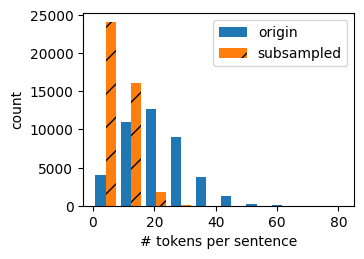

In [7]:
show_list_len_pair_hist(
    ['origin', 'subsampled'], '# tokens per sentence',
    'count', sentences, subsampled);

对于单个词元，高频词“the”的采样率不到1/20。


In [8]:
def compare_counts(token):
    return (f'"{token}"的数量：'
            f'之前={sum([l.count(token) for l in sentences])}, '
            f'之后={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'"the"的数量：之前=50770, 之后=2000'

相比之下，低频词“join”则被完全保留。


In [9]:
compare_counts('join')

'"join"的数量：之前=45, 之后=45'

在下采样之后，我们将词元映射到它们在语料库中的索引。


In [10]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [392, 2115, 145, 18, 406], [5277, 3054, 1580]]

## 中心词和上下文词的提取

下面的`get_centers_and_contexts`函数从`corpus`中提取所有中心词及其上下文词。它随机采样1到`max_window_size`之间的整数作为上下文窗口。对于任一中心词，与其距离不超过采样上下文窗口大小的词为其上下文词。


In [11]:
#@save
def get_centers_and_contexts(corpus, max_window_size):
    """返回跳元模型中的中心词和上下文词"""
    centers, contexts = [], []
    for line in corpus:
        # 要形成“中心词-上下文词”对，每个句子至少需要有2个词
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # 上下文窗口中间i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # 从上下文词中排除中心词
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

接下来，我们创建一个人工数据集，分别包含7个和3个单词的两个句子。设置最大上下文窗口大小为2，并打印所有中心词及其上下文词。


In [12]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('中心词', center, '的上下文词是', context)

数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
中心词 0 的上下文词是 [1, 2]
中心词 1 的上下文词是 [0, 2]
中心词 2 的上下文词是 [0, 1, 3, 4]
中心词 3 的上下文词是 [1, 2, 4, 5]
中心词 4 的上下文词是 [2, 3, 5, 6]
中心词 5 的上下文词是 [4, 6]
中心词 6 的上下文词是 [5]
中心词 7 的上下文词是 [8]
中心词 8 的上下文词是 [7, 9]
中心词 9 的上下文词是 [7, 8]


在PTB数据集上进行训练时，我们将最大上下文窗口大小设置为5。下面提取数据集中的所有中心词及其上下文词。


In [13]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# “中心词-上下文词对”的数量: {sum([len(contexts) for contexts in all_contexts])}'

'# “中心词-上下文词对”的数量: 1502622'

## 负采样

我们使用负采样进行近似训练。为了根据预定义的分布对噪声词进行采样，我们定义以下`RandomGenerator`类，其中（可能未规范化的）采样分布通过变量`sampling_weights`传递。


In [14]:
#@save
class RandomGenerator:
    """根据n个采样权重在{1,...,n}中随机抽取"""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # 缓存k个随机采样结果
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

例如，我们可以在索引1、2和3中绘制10个随机变量$X$，采样概率为$P(X=1)=2/9, P(X=2)=3/9$和$P(X=3)=4/9$，如下所示。


In [15]:
#@save
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[2, 3, 1, 3, 3, 1, 2, 3, 3, 3]

对于一对中心词和上下文词，我们随机抽取了`K`个（实验中为5个）噪声词。根据word2vec论文中的建议，将噪声词$w$的采样概率$P(w)$设置为其在字典中的相对频率，其幂为0.75 :cite:`Mikolov.Sutskever.Chen.ea.2013`。


In [16]:
#@save
def get_negatives(all_contexts, vocab, counter, K):
    """返回负采样中的噪声词"""
    # 索引为1、2、...（索引0是词表中排除的未知标记）
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # 噪声词不能是上下文词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

## 小批量加载训练实例
:label:`subsec_word2vec-minibatch-loading`

在提取所有中心词及其上下文词和采样噪声词后，将它们转换成小批量的样本，在训练过程中可以迭代加载。

在小批量中，$i^\mathrm{th}$个样本包括中心词及其$n_i$个上下文词和$m_i$个噪声词。由于上下文窗口大小不同，$n_i+m_i$对于不同的$i$是不同的。因此，对于每个样本，我们在`contexts_negatives`个变量中将其上下文词和噪声词连结起来，并填充零，直到连结长度达到$\max_i n_i+m_i$(`max_len`)。为了在计算损失时排除填充，我们定义了掩码变量`masks`。在`masks`中的元素和`contexts_negatives`中的元素之间存在一一对应关系，其中`masks`中的0（否则为1）对应于`contexts_negatives`中的填充。

为了区分正反例，我们在`contexts_negatives`中通过一个`labels`变量将上下文词与噪声词分开。类似于`masks`，在`labels`中的元素和`contexts_negatives`中的元素之间也存在一一对应关系，其中`labels`中的1（否则为0）对应于`contexts_negatives`中的上下文词的正例。

上述思想在下面的`batchify`函数中实现。其输入`data`是长度等于批量大小的列表，其中每个元素是由中心词`center`、其上下文词`context`和其噪声词`negative`组成的样本。此函数返回一个可以在训练期间加载用于计算的小批量，例如包括掩码变量。


In [17]:
#@save
def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

让我们使用一个小批量的两个样本来测试此函数。


In [18]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


## 整合代码

最后，我们定义了读取PTB数据集并返回数据迭代器和词表的`load_data_ptb`函数。


In [19]:
def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

In [23]:
class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        assert len(centers) == len(contexts) == len(negatives)
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives

    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index],
                self.negatives[index])

    def __len__(self):
        return len(self.centers)

def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    num_workers = get_dataloader_workers()
    sentences = read_ptb()
    vocab = Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=batchify, num_workers=num_workers)
    return data_iter, vocab

让我们打印数据迭代器的第一个小批量。


In [ ]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

## 小结

* 高频词在训练中可能不是那么有用。我们可以对他们进行下采样，以便在训练中加快速度。
* 为了提高计算效率，我们以小批量方式加载样本。我们可以定义其他变量来区分填充标记和非填充标记，以及正例和负例。

## 练习

1. 如果不使用下采样，本节中代码的运行时间会发生什么变化？
1. `RandomGenerator`类缓存`k`个随机采样结果。将`k`设置为其他值，看看它如何影响数据加载速度。
1. 本节代码中的哪些其他超参数可能会影响数据加载速度？


[Discussions](https://discuss.d2l.ai/t/5735)
